In [45]:
import numpy as np
import keras
from math import sqrt
import pandas as pd
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from battdeg import  pl_samples_file_reader

In [3]:
data_dir = '/home/chintan/uwdirect/chintan/BattDeg/data/PL 12,14/'
file_name_format = 'PL12(3).csv'
ignore_file_indices = [1, 2, 3]
df_pl12 = pl_samples_file_reader(data_dir, file_name_format, ignore_file_indices)

dict_keys([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])


In [4]:
df_pl12.head()

,Time_sec,Date_Time,Step,Cycle,Current_Amp,Voltage_Volt,Charge_Ah,Discharge_Ah,charge_cycle_ah,discharge_cycle_ah,capacity_ah
0,10.000357,735819.421979,1,1,0.0,4.190699,0.0,0.0,0.0,0.0,0.0
1,20.000433,735819.422095,1,1,0.0,4.190699,0.0,0.0,0.0,0.0,0.0
2,30.016045,735819.422211,1,1,0.0,4.190861,0.0,0.0,0.0,0.0,0.0
3,40.031507,735819.422326,1,1,0.0,4.190537,0.0,0.0,0.0,0.0,0.0
4,50.047247,735819.422454,1,1,0.0,4.190861,0.0,0.0,0.0,0.0,0.0


In [13]:
# Converting to an array and only keeping the columns of interest
df_pl12_arr = df_pl12[['Time_sec', 'Current_Amp', 'Voltage_Volt', 'capacity_ah']].values

In [14]:
df_pl12_arr[0:10, :]

array([[1.00003573e+01, 0.00000000e+00, 4.19069910e+00, 0.00000000e+00],
       [2.00004326e+01, 0.00000000e+00, 4.19069910e+00, 0.00000000e+00],
       [3.00160448e+01, 0.00000000e+00, 4.19086123e+00, 0.00000000e+00],
       [4.00315073e+01, 0.00000000e+00, 4.19053745e+00, 0.00000000e+00],
       [5.00472467e+01, 0.00000000e+00, 4.19086123e+00, 0.00000000e+00],
       [6.00002065e+01, 0.00000000e+00, 4.19086123e+00, 0.00000000e+00],
       [6.00005393e+01, 7.49501705e-01, 4.24766350e+00, 4.06994000e-10],
       [7.00008408e+01, 7.54581988e-02, 4.19911432e+00, 2.29201240e-04],
       [8.00008615e+01, 6.60183206e-02, 4.19911432e+00, 4.24199745e-04],
       [9.00163072e+01, 6.02091625e-02, 4.19911432e+00, 5.99097648e-04]])

In [18]:
df_pl12_arr.shape

(1784289, 4)

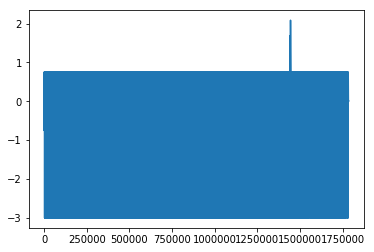

In [167]:
plt.plot(df_pl12_arr[:,1])

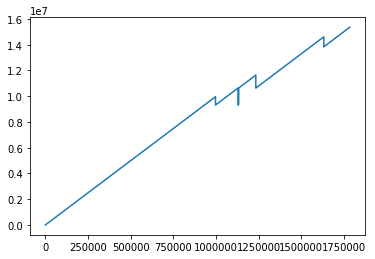

In [17]:
plt.plot(df_pl12_arr[:,0])

In [168]:
# ensure all data is float
values = df_pl12_arr.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [169]:
values.shape

(1784289, 4)

In [170]:
df_pl12_arr_sample = values[0:10000, :]

In [171]:
# Code inspired from Jason Brownlee's posrt here: 
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

# multivariate multi-step encoder-decoder lstm
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores


In [172]:
def split_test_train(data, split_ratio):
    """
    This function splits the data into train and test sets based on the ratio provided. 
    
    Parameters: 
        data (Pandas dataframe): This is the dataframe provided. 
        split_ratio (float): A number between 0 and 1. 
    
    Returns:
        Returns the two dataframes in the ratio 
        
    """
    if not isinstance(split_ratio, float):
        raise(TypeError, "The type of split_ratio is not float")

    if (split_ratio < 0) or (split_ratio > 1):
        raise(ValueError, "The split_error value should be between 0 and 1")

    train_length = split_ratio * len(data)
    # split into standard weeks
    train, test = data[0:round(train_length), :, :], data[round(train_length):, :, :]

    return train, test


In [173]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)


In [174]:
def series_to_supervised(data, n_in=1, n_out=1, out_vars=1, out_var_indices=[3], dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	#print(n_vars)
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]    
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.iloc[:, out_var_indices].shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(out_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(out_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	# Get the values from the dataframe
	agg_values = agg.values
	# Reshape for LSTM friendly input
	agg_values_reshaped = agg_values.reshape(agg_values.shape[0], 1, agg_values.shape[1])
	return agg_values_reshaped
 

In [176]:
s_values = series_to_supervised(values)

In [177]:
s_values[0:10, :, :]

array([[[1.0000358e+01, 0.0000000e+00, 4.1906991e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[2.0000433e+01, 0.0000000e+00, 4.1906991e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[3.0016045e+01, 0.0000000e+00, 4.1908612e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[4.0031506e+01, 0.0000000e+00, 4.1905375e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[5.0047245e+01, 0.0000000e+00, 4.1908612e+00, 0.0000000e+00,
         0.0000000e+00]],

       [[6.0000206e+01, 0.0000000e+00, 4.1908612e+00, 0.0000000e+00,
         4.0699399e-10]],

       [[6.0000538e+01, 7.4950171e-01, 4.2476635e+00, 4.0699399e-10,
         2.2920124e-04]],

       [[7.0000839e+01, 7.5458199e-02, 4.1991143e+00, 2.2920124e-04,
         4.2419974e-04]],

       [[8.0000862e+01, 6.6018321e-02, 4.1991143e+00, 4.2419974e-04,
         5.9909764e-04]],

       [[9.0016304e+01, 6.0209163e-02, 4.1991143e+00, 5.9909764e-04,
         7.5941172e-04]]], dtype=float32)

In [178]:
train_s, test_s = split_test_train(s_values, 0.8)

In [179]:
train_s.shape

(1427430, 1, 5)

In [277]:
train_size = 1000000
test_size = 1000

In [278]:
train_s_X = train_s[0:train_size, :, :-1]

In [279]:
train_s_X.shape

(1000000, 1, 4)

In [280]:
test_s_X = test_s[0:test_size, :, :-1]

In [281]:
test_s_X.shape

(1000, 1, 4)

In [282]:
train_s_y = train_s[0:train_size, :, -1:]

In [283]:
test_s_y = test_s[0:test_size, :, -1:]

In [284]:
test_s_y.shape

(1000, 1, 1)

In [285]:
train_s_y.shape

(1000000, 1, 1)

In [286]:
verbose, epochs, batch_size = 0, 30, 16
n_timesteps, n_features, n_outputs = train_s_X.shape[1], train_s_X.shape[2], train_s_y.shape[1]

In [287]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')

In [288]:
# fit network
model.fit(train_s_X, train_s_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [289]:
test_s_X.shape


(1000, 1, 4)

In [290]:
predictions = model.predict(test_s_X)

In [291]:
predictions.shape

(1000, 1, 1)

In [292]:
score, scores = evaluate_forecasts(test_s_y[:, :, 0], predictions)

In [293]:
score

0.26192150517868645

In [294]:
scores

[0.26192150517868645]

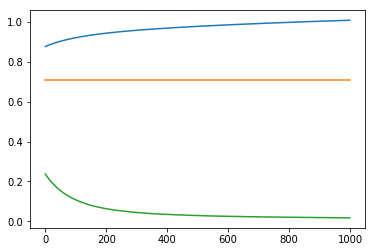

In [295]:
plt.plot(test_s_y[:,0,0])
plt.plot(predictions[:,0,0])
plt.plot(test_s_X[:, 0, 1])